# Neural Style Transfer (NST)

The process of NST assumes an input image p and an example style image a.
The image p is fed through a pretrained CNN, and network activations are sampled at a late convolution layer of the CNN architecture (original paper used VGG-19). Let C(p) be the resulting output sample, called the 'content' of the input p.
The style image a is then fed through the same CNN, and network activations are sampled at the early to middle layers of the CNN. These activations are encoded into a Gramian matrix representation, call it S(a) to denote the 'style' of a.
The goal of NST is to synthesize an output image x that exhibits the content of p applied with the style of a, i.e. C(x)=C(p) and S(x)=S(a).
An iterative optimization (usually gradient descent) then gradually updates x to minimize the loss function error:
L(x)=∣C(x)−C(p)∣+k∣S(x)−S(a)∣, where ∣⋅∣ is the L2 distance. The constant k controls the level of the stylization effect. 

Note: text copied from Wikipedia

c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


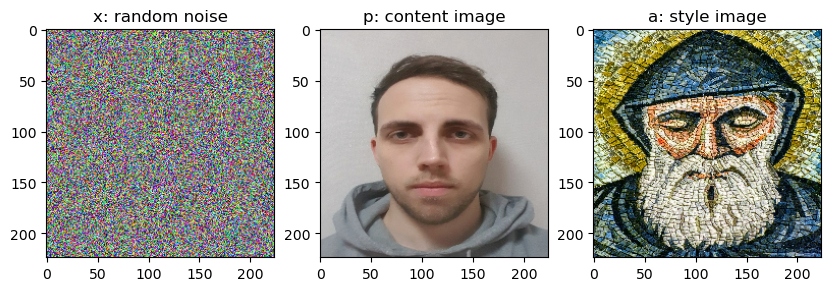

In [1]:
import numpy as numpy
import matplotlib.pyplot as plt
import torch
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x = torch.rand(3, 224, 224).to(device) 
x.requires_grad = True # to optimize it with GD
p = torchvision.io.read_image(path = "./files/profile_pic.jpg").to(device).type(torch.float32)/255.0
a = torchvision.io.read_image(path = "./files/mosaic_style.jpg").to(device).type(torch.float32)/255.0

#resize images to fit expected VGG dimensions
p = torchvision.transforms.functional.resize(img = p, size = [224, 224], interpolation = torchvision.transforms.InterpolationMode.BILINEAR)
a = torchvision.transforms.functional.resize(img = a, size = [224, 224], interpolation = torchvision.transforms.InterpolationMode.BILINEAR)

#show both images next to each other:
plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.title("x: random noise")
plt.imshow(x.permute(1, 2, 0).cpu().detach().numpy())
plt.subplot(1, 3, 2)
plt.title("p: content image")
plt.imshow(p.permute(1, 2, 0).cpu().detach().numpy())
plt.subplot(1, 3, 3)
plt.title("a: style image")
plt.imshow(a.permute(1, 2, 0).cpu().detach().numpy())

The original paper used VGG19 to extract content and style features as follows: 
"The images [...] were synthesised by matching the content representation on layer ‘conv4_2’ (amounts to layer 21)
and the style representation on layers‘conv1_1’ (layer 0), ‘conv2_1’ (layer 5), ‘conv3_1’ (layer 10), ‘conv4_1’ (layer 19) and ‘conv5_1’ (layer 28)
(w_l = 1/5 in those layers, wl = 0 in all other layers)." (p.6 - layer numbers were added)

--> Early layers tend to capture gradients and textures, while later layers tend towards more complex types of feature.

The Neural Style Transfer loss: 
"First, content and style features are extracted and stored. The style image $a$ is passed through the network, and its style representation $A_l$ on all layers included are computed and stored (left). The content image $p$ is passed through the network, and the content representation $P_l$ in one layer is stored (right). Then, a random white noise image $x$ is passed through the network, and its style features $G_l$ and content features $F_l$ are computed. On each layer included in the style representation, the element-wise mean squared difference between $G_l$ and $A_l$ is computed to give the style loss $L_{\text{style}}$ (left). Also, the mean squared difference between $F_l$ and $P_l$ is computed to give the content loss $L_{\text{content}}$ (right). The total loss $L_{\text{total}}$ is then a linear combination between the content and the style loss." (p.4)

![image](./files/Gatys_2016.png)

Note: Image and quotes from L. A. Gatys, A. S. Ecker and M. Bethge, "Image Style Transfer Using Convolutional Neural Networks," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 2414-2423, doi: 10.1109/CVPR.2016.265.

Notes:
- We use the VGG19 model to extract features from the images (as used in the orig. paper)
- The intermediate values for the layers can be obtained using forward hooks
- We need to get the intermediate features of p and a only once (therefore in the init of the loss)
- The intermediate features of x need to be computed every time the loss is called (i.e. in the forward of the loss)

In [9]:
#Let's first look at the model to determine the layers:
import torchvision.models as models
vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
vgg19.eval() # freeze the model
vgg19.to(device) # move the model to GPU

vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [24]:
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
from typing import List

# Create a callable for the hooks
class Get_Layer_Output:
 def __init__(self):
    self.outputs = []

 def __call__(self, module, module_in, module_out):
    self.outputs.append(module_out)

 def clear(self):
    self.outputs = []


class NST_Loss(nn.Module):
    def __init__(
            self, 
            p: Tensor, 
            a: Tensor, 
            p_layers: List, 
            a_layers: List,
            alpha: float = 1.0, #content weight
            beta: float = 1.0 #style weight
            ):
        super().__init__()

        self.alpha = alpha
        self.beta = beta

        # Load the pretrained VGG19 model
        self.vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        self.vgg19.eval() # freeze the model
        self.vgg19.to(device) # move the model to GPU

        # Disable grad (otherwise the NST model will try to step through it as well)
        for param in self.vgg19.features.parameters():
            param.requires_grad = False

        #Normalization and extra dim for VGG19
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        p = self.transform(p)[None,...]
        a = self.transform(a)[None,...]
        
        # Add hooks to the model to extract layer outputs
        self.get_layer_output_p = Get_Layer_Output()
        self.get_layer_output_a = Get_Layer_Output()
        for layer in self.vgg19.features.children():
            if not p_layers and not a_layers:
                break  # Stop iterating once all specified layers are found
            if isinstance(layer, torch.nn.modules.conv.Conv2d):
                if p_layers and layer == self.vgg19.features[p_layers[0]]:
                    layer.register_forward_hook(self.get_layer_output_p)
                    #hook_handles.append(handle)
                    p_layers.pop(0)
                elif a_layers and layer == self.vgg19.features[a_layers[0]]:#
                    layer.register_forward_hook(self.get_layer_output_a)
                    a_layers.pop(0)
        
        dummy_out = self.vgg19(p) #run with p to get p features
        self.p_features = self.get_layer_output_p.outputs 
        self.num_p_layers = len(self.p_features)
        self.get_layer_output_a.clear() #clear hook outputs
        dummy_out = self.vgg19(a) #run with a to get a features
        self.a_features = self.get_layer_output_a.outputs
        self.num_a_layers = len(self.a_features)
        self.get_layer_output_p.clear()
        self.get_layer_output_a.clear()

    def forward(self, x: Tensor) -> Tensor:
        #Get x features
        x = self.transform(x)[None,...]
        model_out = self.vgg19(x)
        p_loss = sum([(self.p_features[i] - self.get_layer_output_p.outputs[i]).pow(2).mean()*(1/self.num_p_layers) for i in range(self.num_p_layers)])
        a_loss = sum([(self.a_features[i] - self.get_layer_output_a.outputs[i]).pow(2).mean()*(1/self.num_a_layers) for i in range(self.num_a_layers)])
        self.get_layer_output_p.clear()
        self.get_layer_output_a.clear()
        return self.alpha*p_loss + self.beta*a_loss

Now, lets create the model and a dummy dataset. The model only takes a random noise image (x) as input and we make it a parameter such that it can be updated.
The training will only consist of handing x to the NST_Loss and updating it based on the difference of its features to the features of the content (p) and style image (a).
Note: We create a dummy dataset because the PL Trainer expects that as input. Additionally, we add a Callback that will only grab the final tuned input image and plot it.

In [44]:
from pytorch_lightning.callbacks import Callback

class Show_Result(Callback):
    def on_train_end(self, trainer, pl_module):
        plt.imshow(pl_module.x.permute(1, 2, 0).cpu().detach().numpy())


class NST_model(pl.LightningModule):
    def __init__(self, x, p, a):
        super().__init__()
        self.x = nn.Parameter(x.clone()) #nn.Parameter specifies that this is an updateable parameter
        self.NST_loss = NST_Loss(
            p = p, 
            a = a, 
            p_layers = [21], 
            a_layers = [0, 5, 10, 19, 28],
            alpha = 1.0, #content weight
            beta = 1.0 #style weight
            )
        
    def forward(self):
        return self.x
    
    def training_step(self, batch, batch_idx):
        loss = self.NST_loss(self.x)
        print(loss)
        #plt.imshow(self.x.permute(1, 2, 0).cpu().detach().numpy())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.3)


class NST_dataset(Dataset):
    def __init__(self):
        pass
    def __len__(self):
        return 1
    def __getitem__(self, idx):
        return 0

Let's train to obtain an image that has the content and style we aim for.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | NST_loss     | NST_Loss | 143 M 
  | other params | n/a      | 150 K 
------------------------------------------
123 M     Trainable params
20.0 M    Non-trainable params
143 M     Total params
575.271   Total estimated model params size (MB)
c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logg

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 41.66it/s, v_num=37]

`Trainer.fit` stopped: `max_epochs=120` reached.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 119: 100%|██████████| 1/1 [00:01<00:00,  0.60it/s, v_num=37]


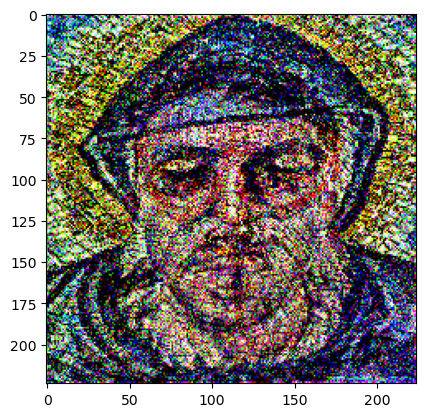

In [45]:
#Normalize all images
x = (x - x.mean())/x.std()
p = (p - p.mean())/p.std()
a = (a - a.mean())/a.std()
model = NST_model(x, p, a)
dataset = NST_dataset()
trainer = pl.Trainer(max_epochs=120, callbacks=[Show_Result()])
dataloader = DataLoader(dataset, batch_size=1)
trainer.fit(model, dataloader)

Seems to go in the right direction... but we would like to improve it.
To break the spatial location constraints of the style influence, we may use a Gramm Matrix.